## **Part 2 | Image Stitching**

Explanation:

The panorama stitching algorithm can be divided into four basic fundamental steps. 

These steps are as follows:

1. Detection of keypoints (points on the image) and extraction of local invariant descriptors (SIFT feature) from input images.
2. Finding matched descriptors between the input images.
3. Calculating the homography matrix using the RANSAC algorithm.
4. The homography matrix is then applied to the image to wrap and fit those images and merge them into one.


then, will compare it with the output of OpenCV's built it stitch() method

In [26]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [27]:
def display_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

1. Loading the images

In [28]:
image_paths=['assets/stitching/pano_image1.jpg','assets/stitching/pano_image2.jpg'] 

imgs = [] 
gray_imgs = []
for i in range(len(image_paths)): 
	imgs.append(cv.cvtColor(cv.imread(image_paths[i]), cv.COLOR_BGR2RGB)) 
	gray_imgs.append(cv.cvtColor(cv.imread(image_paths[i]), cv.COLOR_BGR2GRAY))  


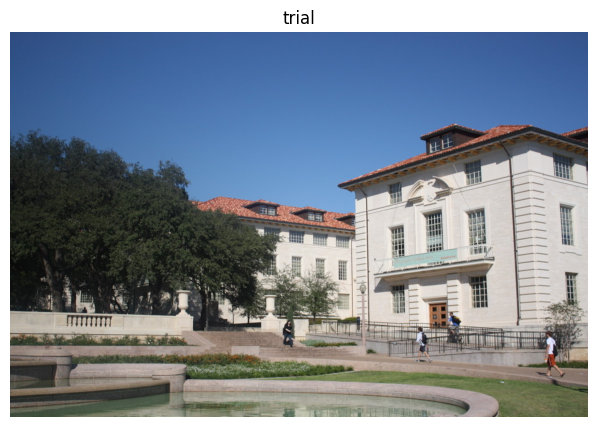

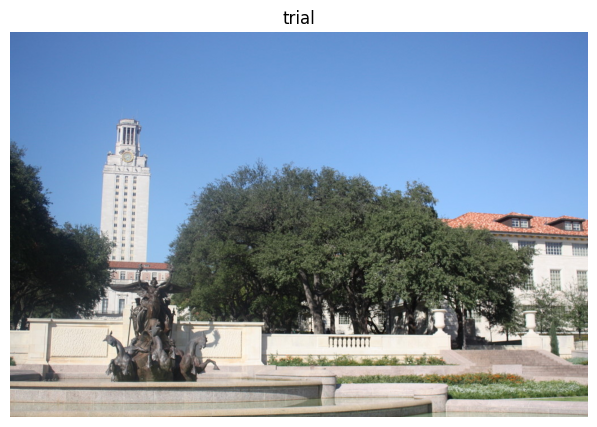

In [29]:
display_image(imgs[0], "trial")
display_image(imgs[1], "trial")

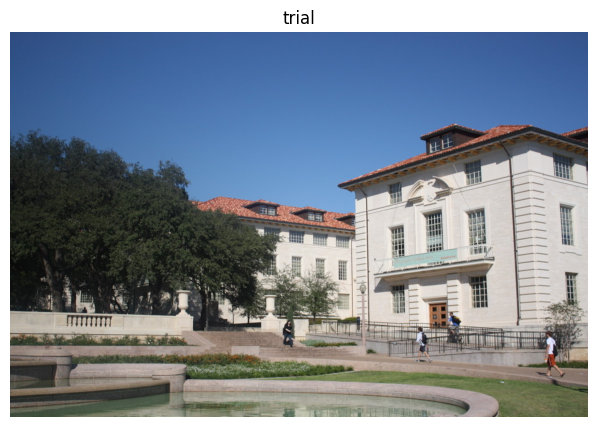

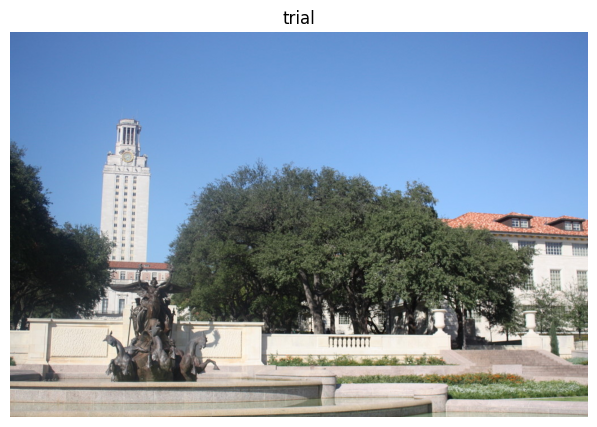

In [30]:
display_image(imgs[0], "trial")
display_image(imgs[1], "trial")

2. Computing SIFT keypoints and descriptors

In [31]:
# sift = cv2.xfeatures2d.SIFT_create()
# kp1 = sift.detect(gray_imgs[0], None)

sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_imgs[0], None) #SIFT works best on grayscale images
kp2, des2 = sift.detectAndCompute(gray_imgs[1], None)
# img1 = cv.drawKeypoints(gray_imgs[0], kp1, imgs[0], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# img2 = cv.drawKeypoints(gray_imgs[1], kp1, imgs[1], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img1 = cv.drawKeypoints(gray_imgs[0], kp1, imgs[0].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv.drawKeypoints(gray_imgs[1], kp2, imgs[1].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


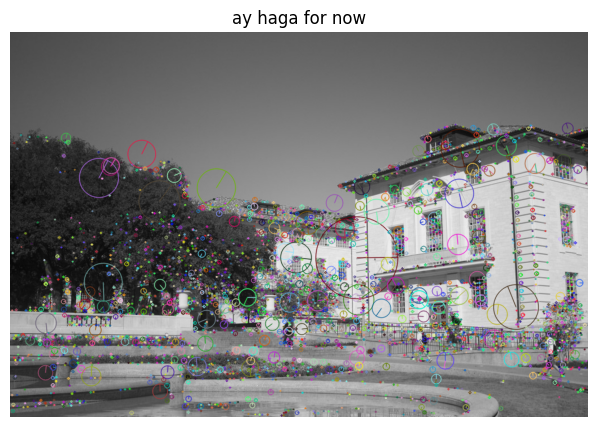

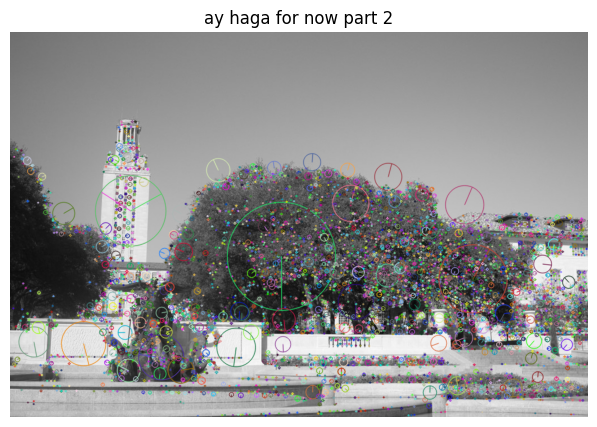

In [32]:
display_image(img1, "ay haga for now")
display_image(img2, "ay haga for now part 2")

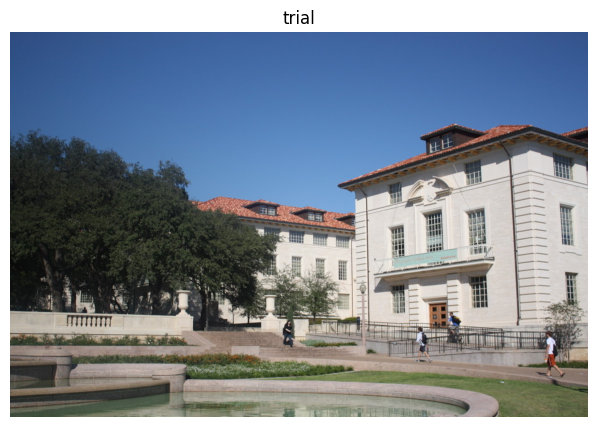

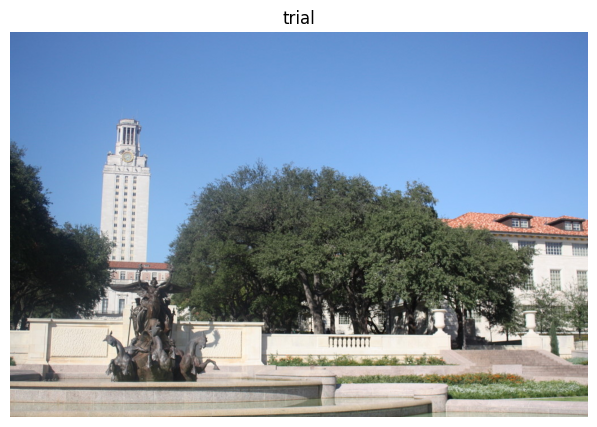

In [33]:
display_image(imgs[0], "trial")
display_image(imgs[1], "trial")

3. Getting Correspondences using Brute Force matcher 

- (may try FLANN as well)

In [34]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)


Applying ratio parameters (best / 2nd-best ratio)

In [36]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

good = sorted(good, key=lambda x: x[0].distance)[:50]

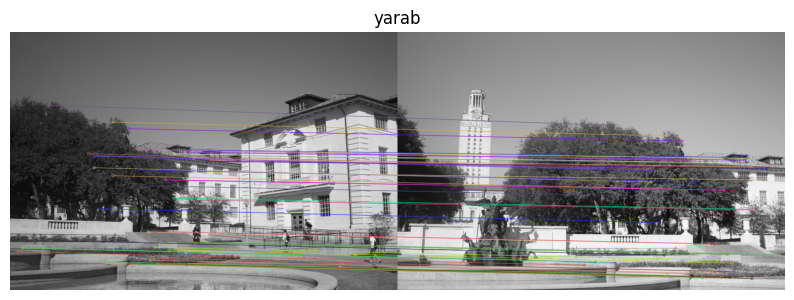

In [37]:
img3 = cv.drawMatchesKnn(gray_imgs[0],kp1,gray_imgs[1],kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_image(img3, "yarab")

4. Computing Homography Transformation

# TO BE CHANGED JUST TRYING BUILTIN OUTPUT

In [ ]:
def get_homography(good, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)
    return H, src_pts, dst_pts

H, src_pts, dst_pts = get_homography(good, kp1, kp2)
print("Homography Matrix:\n", H)



Homography Matrix:
 [[ 7.53078225e-01  3.37134695e-02  4.48971318e+02]
 [-1.38474966e-01  9.04939620e-01  7.78737875e+01]
 [-2.18517431e-04 -3.72226126e-05  1.00000000e+00]]


In [ ]:
def compute_homography_manual(good_matches, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1,  0,  0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([ 0,  0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)

    # Ab = 0 -> SVD stuff
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # normalize so  H[2,2] = 1
    H = H / H[2, 2]

    return H, src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2)

H, src_pts, dst_pts = compute_homography_manual(good, kp1, kp2)
print("Manual Homography Matrix:\n", H)


Manual Homography Matrix:
 [[ 7.56949052e-01  3.88397451e-02  4.47422110e+02]
 [-1.38308959e-01  9.10177620e-01  7.68300997e+01]
 [-2.17860489e-04 -3.18128014e-05  1.00000000e+00]]


Checking correctness of the computed homography matrix

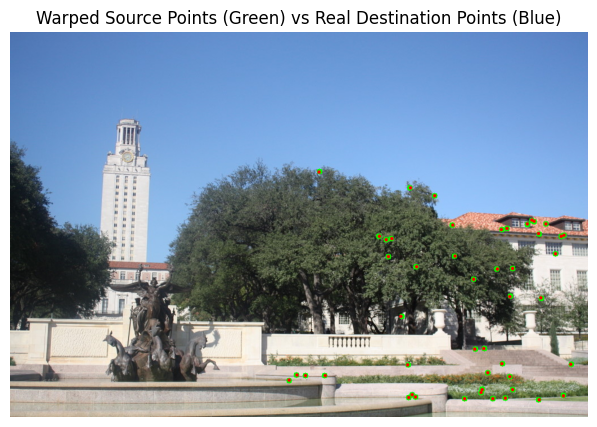

In [44]:
warped_pts = cv.perspectiveTransform(src_pts, H)
img2_verify = imgs[1].copy()
for pt in warped_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
for pt in dst_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
display_image(img2_verify, "Warped Source Points (Green) vs Real Destination Points (Blue)")



5. Warp One Image Into the Other

In [45]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result

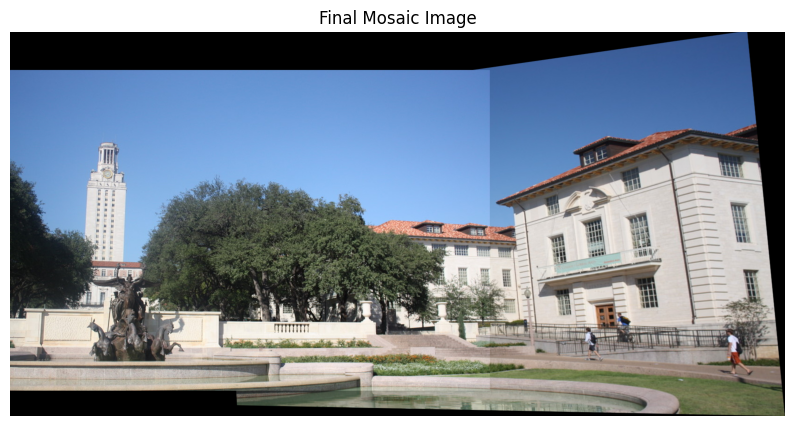

In [46]:
mosaic = warp_images(imgs[0], imgs[1], H)
display_image(mosaic, "Final Mosaic Image")

Resources:
- https://medium.com/@navekshasood/image-stitching-to-create-a-panorama-5e030ecc8f7
- https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
- https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
- https://kushalvyas.github.io/stitching.html
